### Impotrt Packages and Dependancies

In [149]:
from __future__ import absolute_import, division, print_function
import pathlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sql_conn import password
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy import create_engine, Column, Integer, String, Float, Date
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

### Connection to Database on AWS

In [120]:
host="secondawsdb.caa0qcwnjnci.us-east-2.rds.amazonaws.com"
port=3307
dbname="stock_data"
user="root"
password=f"{password}"

# host="localhost"
# port=3306
# dbname="stock_data"
# user="root"
# password=f"{password}"

engine = create_engine(f"mysql://root:{password}@{host}:{port}/stock_data")

Base.metadata.create_all(engine)

from sqlalchemy.orm import Session
session = Session(engine)

### Select Stock Ticker

In [121]:
ticker = "HD"


DJIA = {'MSFT': 'Microsoft',
        'WMT': 'Walmart',
        'V': 'Visa',
        'AXP': 'American Express',
        'PG': 'Proctor and Gamble',
        'CVX': 'Chevron',
        'JNJ': 'Johnson & Johnson',
        'HD': 'Home Depot',
        'KO': 'Coca-Cola',
        'NKE': 'Nike',
        'JPM': 'JP Morgan Chase',
        'MCD': 'McDonalds',
        'UTX': 'United Technologies',
        'MMM': '3M',
        'AAPL': 'Apple',
        'GS': 'Goldman Sachs',
        'IBM': 'IBM',
        'TRV': 'The Travelers Company',
        'VZ': 'Verizon',
        'CSCO': 'Cisco',
        'DIS': 'Disney',
        'UNH': 'United Health',
        'XOM': 'Exxon Mobil',
        'MRK': 'Merck & Co.',
        'BA': 'Bank of America',
        'INTC': 'Intel',
        'DWDP': 'DowDuPont',
        'CAT': 'Caterpillar',
        'PFE': 'Pfizer',
        'WBA': 'Walgreens Boots Alliance'}

### Query Database

In [122]:
stoch_sql = (f'SELECT * FROM stock_data.STOCH_{ticker}')
stoch = pd.read_sql(stoch_sql, engine)
stoch = stoch.drop(['level_0'], axis=1)

adx_sql = (f'SELECT * FROM stock_data.ADX_{ticker}')
adx = pd.read_sql(adx_sql, engine)
adx = adx.drop(['level_0', 'Symbol'], axis=1)

macd_sql = (f'SELECT * FROM stock_data.MACD_{ticker}')
macd = pd.read_sql(macd_sql, engine)
macd = macd.drop(['level_0', 'Symbol'], axis=1)

ema_sql = (f'SELECT * FROM stock_data.EMA_{ticker}')
ema = pd.read_sql(ema_sql, engine)
ema = ema.drop(['level_0', 'Symbol'], axis=1)

bbands_sql = (f'SELECT * FROM stock_data.BBANDS_{ticker}')
bbands = pd.read_sql(bbands_sql, engine)
bbands = bbands.drop(['level_0', 'Symbol'], axis=1)

rsi_sql = (f'SELECT * FROM stock_data.RSI_{ticker}')
rsi = pd.read_sql(rsi_sql, engine)
rsi = rsi.drop(['level_0', 'Symbol'], axis=1)

hist_sql = (f'SELECT * FROM stock_data.historical_data_{ticker}')
hist = pd.read_sql(hist_sql, engine)
hist = hist.drop(['ticker'], axis=1)

### Join DataFrames Returned from SQL Query

In [123]:
join1 = stoch.join(adx.set_index('index'), on='index')

join2 = join1.join(bbands.set_index('index'), on='index')

join3 = join2.join(ema.set_index('index'), on='index')

join4 = join3.join(macd.set_index('index'), on='index')

join5 = join4.join(rsi.set_index('index'), on='index')

stock_df = join5

### Check Ticker and Date Range

In [124]:
join1.describe()

,index,SlowD,SlowK,Symbol,ADX
count,5321,5321,5321,5321,5290
unique,5321,5302,5297,1,5234
top,2005-08-05,58.9189,75.4723,HD,16.0545
freq,1,2,2,5321,3


In [125]:
join1.head(1)

,index,SlowD,SlowK,Symbol,ADX
0,1998-01-14,59.7774,83.4156,HD,NaN


In [126]:
join1.tail(1)

,index,SlowD,SlowK,Symbol,ADX
5320,2019-03-08,34.0887,32.2617,HD,14.7781


In [127]:
hist.head(1)

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,1990-01-02,36.75,37.75,36.38,37.75,306415.0,0.0,1.0,1.252295,1.286371,1.239686,1.286371,6204903.75


In [128]:
hist.tail(1)

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
7113,2018-03-27,177.38,178.73,173.6,174.68,4640376.0,0.0,1.0,177.38,178.73,173.6,174.68,4640376.0


In [129]:
stock_df = stock_df.dropna()

stock_df = stock_df.rename(columns={'index':'Date'})

stock_combo = stock_df.set_index('Date').join(hist.set_index('Date'))


In [130]:
stock_combo.head(1)

,SlowD,SlowK,Symbol,ADX,Real Lower Band,Real Middle Band,Real Upper Band,EMA,MACD_Hist,MACD_Signal,...,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-02,18.1057,17.8192,HD,27.6600,59.5815,64.8855,70.1895,64.5300,0.0700,0.6278,...,63.63,64.63,2262900.0,0.0,1.0,15.027139,15.364854,15.027139,15.263303,6788700.0


In [131]:
stock_combo.dtypes

SlowD                object
SlowK                object
Symbol               object
ADX                  object
Real Lower Band      object
Real Middle Band     object
Real Upper Band      object
EMA                  object
MACD_Hist            object
MACD_Signal          object
MACD                 object
RSI                  object
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Ex-Dividend         float64
Split Ratio         float64
Adj. Open           float64
Adj. High           float64
Adj. Low            float64
Adj. Close          float64
Adj. Volume         float64
dtype: object

In [132]:
stock_combo['SlowK'] = stock_combo['SlowK'].astype(float)
stock_combo['SlowD'] = stock_combo['SlowD'].astype(float)
stock_combo['ADX'] = stock_combo['ADX'].astype(float)
stock_combo['Real Upper Band'] = stock_combo['Real Upper Band'].astype(float)
stock_combo['Real Middle Band'] = stock_combo['Real Middle Band'].astype(float)
stock_combo['Real Lower Band'] = stock_combo['Real Lower Band'].astype(float)
stock_combo['EMA'] = stock_combo['EMA'].astype(float)
stock_combo['MACD_Signal'] = stock_combo['MACD_Signal'].astype(float)
stock_combo['MACD_Hist'] =stock_combo['MACD_Hist'].astype(float)
stock_combo['MACD'] = stock_combo['MACD'].astype(float)
stock_combo['RSI'] = stock_combo['RSI'].astype(float)

In [133]:
stock_combo = stock_combo.drop(columns=["Symbol"])

In [134]:
stock_combo.insert(0, "date", stock_combo.index)

In [135]:
stock_combo.head(1)

,date,SlowD,SlowK,ADX,Real Lower Band,Real Middle Band,Real Upper Band,EMA,MACD_Hist,MACD_Signal,...,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-02,1998-03-02,18.1057,17.8192,27.66,59.5815,64.8855,70.1895,64.53,0.07,0.6278,...,63.63,64.63,2262900.0,0.0,1.0,15.027139,15.364854,15.027139,15.263303,6788700.0


In [136]:
#stock_combo.reset_index(drop='False')

Text(0, 0.5, 'Adjusted Closing Price')

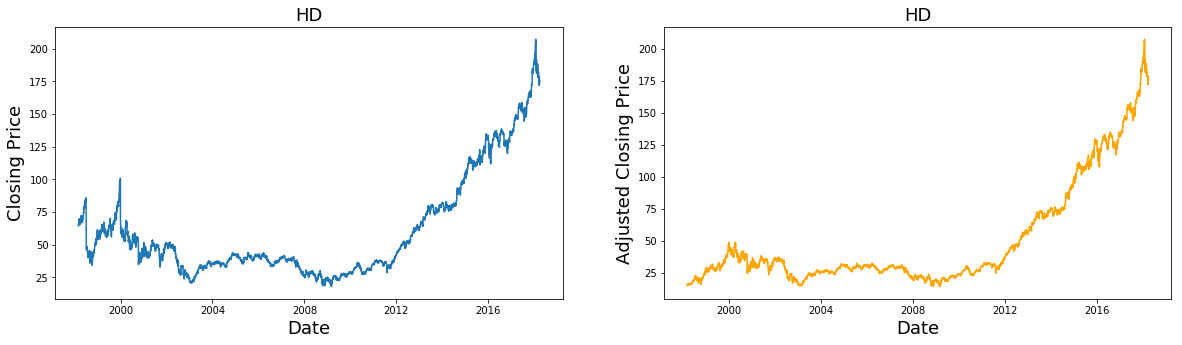

In [156]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(stock_combo['Close'])
#plt.xticks(stock_combo['date'])
plt.title(f'{ticker}', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)


plt.subplot(1, 2, 2)
plt.plot(stock_combo['Adj. Close'], color='orange')
#plt.xticks(stock_combo['date'])
plt.title(f'{ticker}', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adjusted Closing Price',fontsize=18)

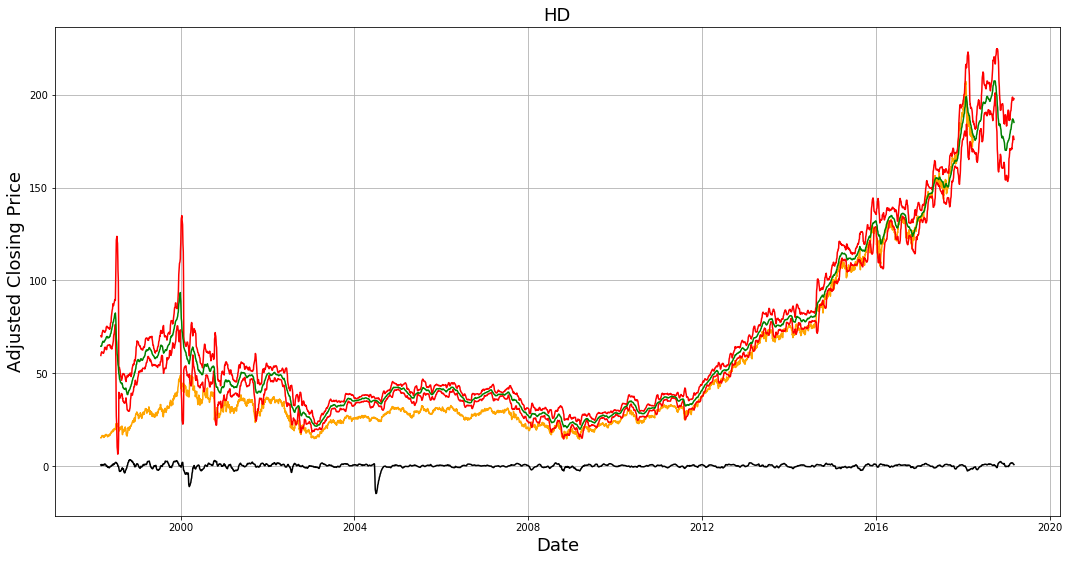

In [159]:

plt.figure(figsize = (18,9))
plt.plot(stock_combo['Adj. Close'], color='orange')
plt.plot(stock_combo['Real Upper Band'], color='red')
plt.plot(stock_combo['Real Lower Band'], color='red')
plt.plot(stock_combo['EMA'], color='green')
plt.plot(stock_combo['MACD'], color='black')
#plt.plot(stock_combo['Real Middle Band'], color='red')
#plt.xticks(stock_combo['date'])
plt.title(f'{ticker}', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adjusted Closing Price',fontsize=18)
plt.grid(b=None, which='major', axis='both')
plt.savefig("output_images/stock_charts/AAPL_close_adj.png")
plt.show()

In [133]:
high_prices = stock_combo.loc[:,'High'].as_matrix()
low_prices = stock_combo.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

X:\Users\cwess_000\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
X:\Users\cwess_000\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [140]:
training_set = stock_combo.iloc[:, 1:2].values

In [142]:
stock_combo.head()

,date,SlowK,SlowD,Symbol,ADX,Real Middle Band,Real Lower Band,Real Upper Band,EMA,MACD_Hist,...,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,,,,,,,,,,
1998-10-19,1998-10-19,81.0594,88.1549,PG,20.9423,75.9710,63.9886,87.9534,77.4312,1.1577,...,82.00,82.06,1935300.0,0.000,1.0,25.741990,25.741990,25.315942,25.334466,3870600.0
1998-10-20,1998-10-20,72.2469,81.6442,PG,21.0061,76.5085,64.2961,88.7209,77.8844,1.0167,...,81.44,82.19,2790300.0,0.000,1.0,25.315942,25.856221,25.143052,25.374601,5580600.0
1998-10-21,1998-10-21,71.3832,74.8965,PG,20.9452,76.9520,63.9037,90.0003,78.4487,0.9687,...,80.94,83.81,2024800.0,0.285,1.0,25.324585,25.984418,25.073662,25.962733,4049600.0
1998-10-22,1998-10-22,82.2930,75.3077,PG,21.3508,77.6710,63.4922,91.8498,79.2517,1.0720,...,83.00,86.88,4300900.0,0.000,1.0,25.962733,26.950934,25.711811,26.913760,8601800.0
1998-10-23,1998-10-23,91.6340,81.7701,PG,21.8693,78.5180,63.8760,93.1600,80.0316,1.1019,...,86.44,87.44,3723300.0,0.000,1.0,26.950934,27.260715,26.777457,27.087238,7446600.0


In [143]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [144]:
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [148]:
len(X_train)

1975

In [145]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [146]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1975/1975 [==============================] - 8s 4ms/step - loss: 0.0921
Epoch 2/100
1975/1975 [==============================] - 5s 3ms/step - loss: 0.0666
Epoch 3/100
1975/1975 [==============================] - 5s 3ms/step - loss: 0.0653
Epoch 4/100
1975/1975 [==============================] - 5s 3ms/step - loss: 0.0647
Epoch 5/100
1975/1975 [==============================] - 5s 3ms/step - loss: 0.0629
Epoch 6/100
1975/1975 [==============================] - 5s 2ms/step - loss: 0.0631
Epoch 7/100
1975/1975 [==============================] - 5s 2ms/step - loss: 0.0615
Epoch 8/100
1975/1975 [==============================] - 5s 2ms/step - loss: 0.0603
Epoch 9/100
1975/1975 [==============================] - 5s 2ms/step - loss: 0.0567
Epoch 10/

1975/1975 [==============================] - 6s 3ms/step - loss: 0.0090
Epoch 87/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0087
Epoch 88/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0086
Epoch 89/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0089
Epoch 90/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0088
Epoch 91/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0087
Epoch 92/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0087
Epoch 93/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0088
Epoch 94/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0089A: 1s - l
Epoch 95/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0089
Epoch 96/100
1975/1975 [==============================] - 6s 3ms/step - loss: 0.0087
Epoch 97/100
1975/1975 [==============================] - 6s 3ms/step

In [151]:

real_stock_price = stock_combo.iloc[:, 1:2].values

In [152]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [154]:
dataset_total = pd.concat((training_set["Open"], training_set["Open"]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [134]:
train_data = mid_prices[:2600]
test_data = mid_prices[2600:]

In [135]:
test_data

array([50.5778, 49.64  , 49.575 , ...,     nan,     nan,     nan])

In [136]:
train_data

array([82.69 , 82.595, 82.41 , ..., 50.11 , 50.46 , 51.54 ])

In [137]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_data)

ValueError: Expected 2D array, got 1D array instead:
array=[82.69  82.595 82.41  ... 50.11  50.46  51.54 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [123]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data

scaler = MinMaxScaler()
train_data = train_data.reshape(1,-1)
test_data = test_data.reshape(-1,1)

In [128]:
train_data.reshape(1,-1)

array([[82.69 , 82.595, 82.41 , ..., 50.11 , 50.46 , 51.54 ]])

In [129]:
smoothing_window_size = 500

In [130]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500

for x in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[x:x+smoothing_window_size])
    scaler.transform(train_data[x:x+smoothing_window_size])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size])
train_data[di+smoothing_window_size] = scaler.transform(train_data[di+smoothing_window_size])

ValueError: Found array with 0 sample(s) (shape=(0, 2600)) while a minimum of 1 is required by MinMaxScaler.

In [66]:
stock_train = stock_combo.drop(stock_combo.index[2601:])

In [125]:
stock_test = stock_combo.drop(stock_train.index)

In [126]:
train_dataset = stock_train.sample(frac=0.9,random_state=2)
test_dataset = stock_test

In [127]:
train_stats = stock_train.describe()
#train_stats

In [128]:
train_stats.pop("Close")
train_stats = train_stats.transpose()
#train_stats

In [129]:
train_labels = train_dataset.pop('Close')
test_labels = test_dataset.pop('Close')

In [130]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [131]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [132]:
model = build_model()

In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                1472      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [134]:
example_batch = normed_train_data[:20]
example_result = model.predict(example_batch)
example_result

array([[ 0.22358114],
       [-0.65498674],
       [ 0.15421769],
       [-0.75548697],
       [ 0.05089545],
       [-0.11178732],
       [-0.3123728 ],
       [ 0.13737634],
       [-0.14284551],
       [-0.12714297],
       [ 0.04644802],
       [ 0.22495891],
       [ 0.06475228],
       [-1.5436902 ],
       [ 0.22900543],
       [-0.05443822],
       [ 0.2750868 ],
       [-0.16590014],
       [ 0.21429057],
       [-0.16673942]], dtype=float32)

In [135]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [136]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.371605,0.459741,0.371605,2.542912,1.146839,2.542912,995
996,0.371654,0.435185,0.371654,1.958999,0.892709,1.958999,996
997,0.330023,0.417860,0.330023,0.860124,0.276177,0.860124,997
998,0.371752,0.464831,0.371752,1.008322,0.466459,1.008322,998
999,0.369111,0.456542,0.369111,0.927385,0.305685,0.927385,999


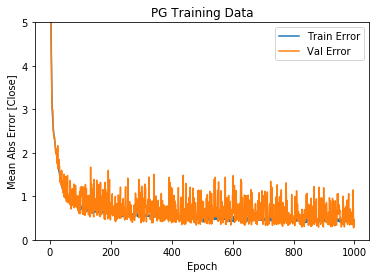

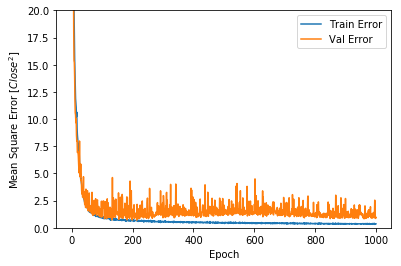

<Figure size 432x288 with 0 Axes>

In [138]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Close]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error'), plt.title(f'{ticker} Training Data'), plt.savefig(f'output_images/{ticker}_line.png')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error'), plt.title(f'{ticker} Training Data'), plt.savefig(f'output_images/{ticker}_line2.png')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Close^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error'), plt.savefig(f'output_images/{ticker}_line3.png')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error'), plt.savefig(f'output_images/{ticker}_line4.png')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
 #plt.savefig(f'output_images/{ticker}.png')
    

plot_history(history) 
#plt.savefig(f'output_images/{ticker}_line5.png')


.............................................................................................

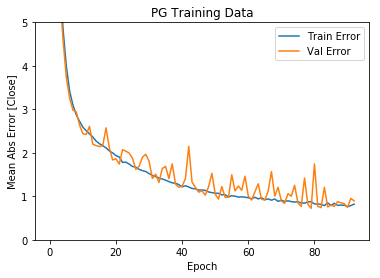

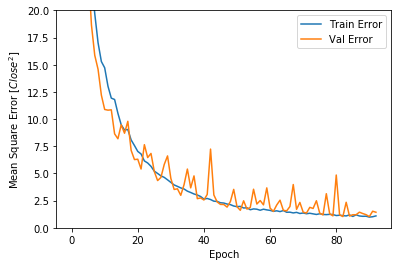

In [139]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
             

In [86]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)



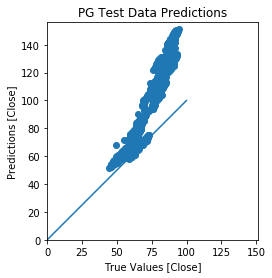

In [140]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Close]')
plt.ylabel('Predictions [Close]')
plt.title(f'{ticker} Test Data Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = (plt.plot([-100, 100], [-100, 100]), plt.savefig(f'output_images/{ticker}_test_predictions.png'))

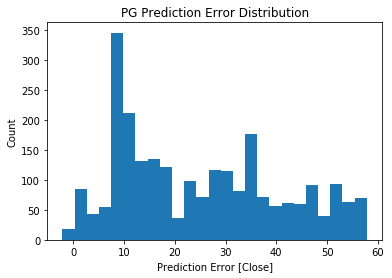

In [141]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.title(f'{ticker} Prediction Error Distribution')
plt.xlabel("Prediction Error [Close]")
plt.savefig(f'output_images/{ticker}_prediction_error.png')
#_ = plt.ylabel("Count")

In [ ]:
# CODE FOR CHARTS

# x_axis1 = city_weather['latitude']; x_axis2 = city_weather['latitude']; x_axis3 = city_weather['latitude']; 
# x_axis4 = city_weather['latitude']; y_axis1 = ((city_weather['temp_max'] - 273.15)*9/5 + 32); 
# y_axis2 = city_weather['humidity']; y_axis3 = city_weather['clouds']; y_axis4 = city_weather['wind_speed']
# lat_vs_temp = (plt.scatter(x_axis1, y_axis1, linewidth=1, edgecolors="black"), 
#                plt.xlabel("Latitude"), plt.ylabel("Temperature(F)"), plt.title("City Latitude vs. Max Temperature 10/29/18"), 
#                plt.grid(b=None, which='major', axis='both'), plt.savefig("output_images/lat_vs_temp.png"))